In [1]:
import tensorflow as tf
import keras 
import numpy as np

Using TensorFlow backend.


In [2]:
# (Both robust and non-robust) Data samples generation
import random
from math import sqrt, pi, cos, sin

def create_single_sample(distance, radius):
    if random.random() < 1/3:
        center, y = [sqrt(3)/2, 1/2], 0
    elif random.random() < 1/3:
        center, y = [-sqrt(3)/2, 1/2], 1
    else:
        center, y = [0.0, -1.0], 2
        
    alpha = 2 * pi * random.random()
    r = radius * random.random()
    x = np.array(center) * distance
    
    x[0] = x[0] + r * cos(alpha)
    x[1] = x[1] + r * sin(alpha)
    
    return (x, y)
        
def create_robust_dataset(num_of_sample):
    X, Y = np.zeros((num_of_sample, 2)), np.zeros(num_of_sample)
    for i in range(num_of_sample):
        (x, y) = create_single_sample(2, 1)
        X[i], Y[i] = x, y

    return (X, Y)

def create_non_robust_dataset(num_of_sample):
    X, Y = np.zeros((num_of_sample, 2)), np.zeros(num_of_sample)
    for i in range(num_of_sample):
        (x, y) = create_single_sample(2, 3)
        X[i], Y[i] = x, y

    return (X, Y)

def create_test_dataset(num_of_sample):
    X, Y = np.zeros((num_of_sample, 2)), np.zeros(num_of_sample)
    for i in range(num_of_sample):
        (x, y) = create_single_sample(2, 2)
        X[i], Y[i] = x, y
        
    return (X, Y)

size_of_dataset = 600
robust_X, robust_Y = create_robust_dataset(size_of_dataset)
print(robust_X.shape, robust_Y.shape)
non_robust_X, non_robust_Y = create_non_robust_dataset(size_of_dataset)
print(non_robust_X.shape, non_robust_Y.shape)

test_X, test_Y = create_non_robust_dataset(1000)
print(test_X.shape, test_Y.shape)


(600, 2) (600,)
(600, 2) (600,)
(1000, 2) (1000,)


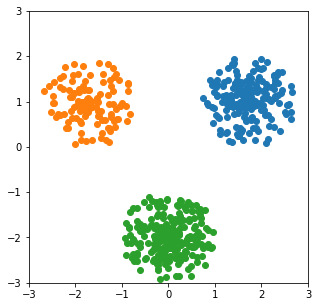

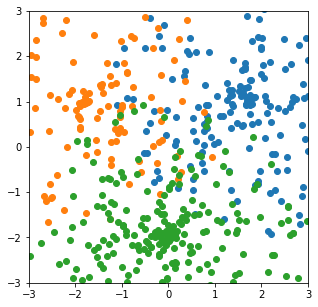

In [3]:
# (Both robust and non-robust) Viusalization 
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(5,5))

for label_idx in range(3):
    X = [x[0] for (idx, x) in enumerate(robust_X) if robust_Y[idx] == label_idx]
    Y = [x[1] for (idx, x) in enumerate(robust_X) if robust_Y[idx] == label_idx]
    plt.scatter(X, Y)
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.show()

figure(figsize=(5,5))
for label_idx in range(3):
    X = [x[0] for (idx, x) in enumerate(non_robust_X) if non_robust_Y[idx] == label_idx]
    Y = [x[1] for (idx, x) in enumerate(non_robust_X) if non_robust_Y[idx] == label_idx]
    plt.scatter(X, Y)
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.show()

In [4]:
from math import inf
from numpy.linalg import norm
def return_close_i(i, X_cluster_mean):
    min_j, min_distance = None, inf
    for j in range(len(X_cluster_mean)):
        if i != j:
            distance = norm(X_cluster_mean[j] - X_cluster_mean[i])
            if distance < min_distance:
                min_distance, min_j = distance, j
    return min_j, min_distance

def compute_robustness_indication(X, Y):
    X0 = np.array([x for (idx, x) in enumerate(X) if Y[idx] == 0])
    X1 = np.array([x for (idx, x) in enumerate(X) if Y[idx] == 1])
    X2 = np.array([x for (idx, x) in enumerate(X) if Y[idx] == 2])

    X_cluster = [X0, X1, X2]
    X_cluster_mean = [np.mean(X, axis=0) for X in X_cluster]
    X_cluster_std = [np.std(X, axis=0) for X in X_cluster]

    r = 0
    for i in range(3):
        close_i, close_i_distance = return_close_i(i, X_cluster_mean)
        r += close_i_distance - norm(X_cluster_std[i]) - norm(X_cluster_std[close_i])
    return r

robust_r = compute_robustness_indication(robust_X, robust_Y)
non_robust_r = compute_robustness_indication(non_robust_X, non_robust_Y)

print('Robustness indication (robust dataset):', robust_r)
print('Robustness indication (non robust dataset):', non_robust_r)

Robustness indication (robust dataset): 6.718791343181129
Robustness indication (non robust dataset): 0.2507497751101635


In [5]:
# Create two models corresponding to robust and non-robust dataset 
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class NaiveC(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(2, 5)
        self.layer2 = nn.Linear(5, 5)
        self.layer3 = nn.Linear(5, 3)
        self.relu = nn.ReLU()

    def forward(self, x):
        h1 = self.relu(self.layer1(x))
        output = self.relu(self.layer2(h1))
        return self.layer3(output)

def generate_NaiveC(X, Y):
    model = NaiveC()

    # Optimizer parameters
    loss_func = nn.CrossEntropyLoss()
    lr = 1e-3
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_history = []
    
    # Training
    num_of_epochs = 15
    for epoch in range(num_of_epochs):
        print(epoch+1, '/', num_of_epochs)
        for idx, data in enumerate(X):

            data = torch.from_numpy(np.expand_dims(data, axis=0).astype(np.float32))
            label = torch.from_numpy(np.array([Y[idx]]).astype(np.int64))
    
            # Forwarding
            prediction = model.forward(data)
            loss = loss_func(prediction, label)

            # Optimization (back-propogation)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_history.append(loss.item())
            
    return loss_history, model
            
robust_loss_history, robust_model = generate_NaiveC(robust_X, robust_Y)

print()
non_robust_loss_history, non_robust_model = generate_NaiveC(non_robust_X, non_robust_Y)

1 / 15
2 / 15
3 / 15
4 / 15
5 / 15
6 / 15
7 / 15
8 / 15
9 / 15
10 / 15
11 / 15
12 / 15
13 / 15
14 / 15
15 / 15

1 / 15
2 / 15
3 / 15
4 / 15
5 / 15
6 / 15
7 / 15
8 / 15
9 / 15
10 / 15
11 / 15
12 / 15
13 / 15
14 / 15
15 / 15


In [6]:
def eval_model(X, Y, model):
    datas = torch.from_numpy(X.astype(np.float32))
    labels = torch.from_numpy(Y.astype(np.int64))

    # Forwarding
    outputs = model.forward(datas).detach().numpy()
    predictions = np.argmax(outputs, axis=1)

    total = labels.shape[0]
    correct = (predictions == labels.numpy()).sum().item()
    acc = correct/total
    
    return acc

robust_acc = eval_model(test_X, test_Y, robust_model)
print('Robust model accurancy:', robust_acc)

non_robust_acc = eval_model(test_X, test_Y, non_robust_model)
print('Non robust model accurancy:', non_robust_acc)

Robust model accurancy: 0.839
Non robust model accurancy: 0.842


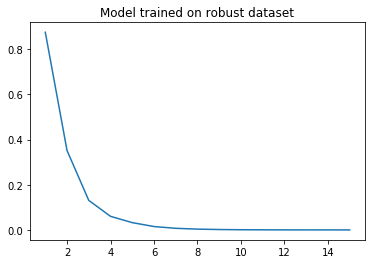

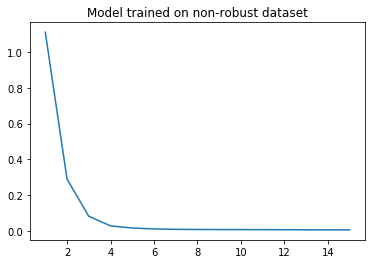

In [7]:
# Visualize the training process 
y = [robust_loss_history[i] for i in np.arange(len(robust_loss_history)) if (i+1)%size_of_dataset==0]
x = [i+1 for i in np.arange(len(y))]
x = np.array(x)
plt.plot(x, y)
plt.title('Model trained on robust dataset')
plt.show()

y = [non_robust_loss_history[i] for i in np.arange(len(non_robust_loss_history)) if (i+1)%size_of_dataset==0]
x = [i+1 for i in np.arange(len(y))]
x = np.array(x)
plt.plot(x, y)
plt.title('Model trained on non-robust dataset')
plt.show()

In [8]:
# Measure attack success rate 
# 1. Design (apply) adversarial attacks 
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + (epsilon * sign_data_grad)
    # Return the perturbed image
    return perturbed_image

def test(model, epsilon, X, Y):

    # Accuracy counter
    correct = 0
    success_count = 0
    adv_examples = []

    # Loop over all examples in test set
    for idx, data in enumerate(X):
        data = torch.from_numpy(np.expand_dims(data, axis=0).astype(np.float32))
        target = np.array([Y[idx]]).astype(np.int64)
        target = torch.from_numpy(target)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model.forward(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model.forward(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
        else:
            success_count += 1

    # Calculate final accuracy for this epsilon
    final_sucess_rate = success_count/float(Y.shape[0])
    print("Epsilon: {}\tSuccess Rate = {} / {} = {}".format(epsilon, success_count, Y.shape[0], final_sucess_rate))
    
    return final_sucess_rate

epsilons = [0, .05, .1, .15, .2, .25, .3, .4, .5, .6, .7, .8, .9]
robust_pretrained_model = robust_model.eval()
non_robust_pretrained_model = non_robust_model.eval()
use_cuda=False

robust_attack_success_rate, non_robust_attack_success_rate = [], []
# Run test for each epsilon (robust)
for eps in epsilons:
    robust_attack_success_rate.append(test(robust_model, eps, test_X, test_Y))
    
print()
# Run test for each epsilon (non robust)
for eps in epsilons:
    non_robust_attack_success_rate.append(test(non_robust_model, eps, test_X, test_Y))

Epsilon: 0	Success Rate = 0 / 1000 = 0.0
Epsilon: 0.05	Success Rate = 16 / 1000 = 0.016
Epsilon: 0.1	Success Rate = 25 / 1000 = 0.025
Epsilon: 0.15	Success Rate = 44 / 1000 = 0.044
Epsilon: 0.2	Success Rate = 57 / 1000 = 0.057
Epsilon: 0.25	Success Rate = 69 / 1000 = 0.069
Epsilon: 0.3	Success Rate = 79 / 1000 = 0.079
Epsilon: 0.4	Success Rate = 103 / 1000 = 0.103
Epsilon: 0.5	Success Rate = 134 / 1000 = 0.134
Epsilon: 0.6	Success Rate = 170 / 1000 = 0.17
Epsilon: 0.7	Success Rate = 200 / 1000 = 0.2
Epsilon: 0.8	Success Rate = 234 / 1000 = 0.234
Epsilon: 0.9	Success Rate = 277 / 1000 = 0.277

Epsilon: 0	Success Rate = 0 / 1000 = 0.0
Epsilon: 0.05	Success Rate = 13 / 1000 = 0.013
Epsilon: 0.1	Success Rate = 24 / 1000 = 0.024
Epsilon: 0.15	Success Rate = 34 / 1000 = 0.034
Epsilon: 0.2	Success Rate = 47 / 1000 = 0.047
Epsilon: 0.25	Success Rate = 57 / 1000 = 0.057
Epsilon: 0.3	Success Rate = 68 / 1000 = 0.068
Epsilon: 0.4	Success Rate = 93 / 1000 = 0.093
Epsilon: 0.5	Success Rate = 124 / 

In [9]:
print('Robustness indication (robust dataset):', robust_r)
print('Robustness indication (non robust dataset):', non_robust_r)

great_indication_count = 0
num_of_comparision = len(robust_attack_success_rate)
if robust_r < non_robust_r:
    for i in range(num_of_comparision):
        if robust_attack_success_rate[i] >= non_robust_attack_success_rate[i]:
            great_indication_count += 1
elif robust_r > non_robust_r:
    for i in range(num_of_comparision):
        if robust_attack_success_rate[i] <= non_robust_attack_success_rate[i]:
            great_indication_count += 1
else:
    print('Weird, it merely impossible for two robustness indication to the same!')

print(great_indication_count, num_of_comparision, great_indication_count/num_of_comparision)

Robustness indication (robust dataset): 6.718791343181129
Robustness indication (non robust dataset): 0.2507497751101635
1 13 0.07692307692307693


In [10]:
num_of_trails = 100
cum_related_rate = 0

for trail in range(num_of_trails):
    print('Trail :', trail)
    size_of_dataset = 300
    robust_X, robust_Y = create_robust_dataset(size_of_dataset)
    non_robust_X, non_robust_Y = create_non_robust_dataset(size_of_dataset)

    robust_r = compute_robustness_indication(robust_X, robust_Y)
    non_robust_r = compute_robustness_indication(non_robust_X, non_robust_Y)

    robust_loss_history, robust_model = generate_NaiveC(robust_X, robust_Y)
    non_robust_loss_history, non_robust_model = generate_NaiveC(non_robust_X, non_robust_Y)

    epsilons = [0, .05, .1, .15, .2, .25, .3, .4, .5, .6, .7, .8, .9]
    epsilons = [.5, .6, .7, .8, .9, .95]
    epsilons = [.8]
    epsilons = [0, .05, .1, .15, .2, .25, .3, .4]
    epsilons = [.5]
    
    
    robust_pretrained_model = robust_model.eval()
    non_robust_pretrained_model = non_robust_model.eval()
    use_cuda=False

    robust_attack_success_rate, non_robust_attack_success_rate = [], []
    # Run test for each epsilon (robust)
    for eps in epsilons:
        robust_attack_success_rate.append(test(robust_model, eps, test_X, test_Y))

    # Run test for each epsilon (non robust)
    for eps in epsilons:
        non_robust_attack_success_rate.append(test(non_robust_model, eps, test_X, test_Y))

    great_indication_count = 0
    num_of_comparision = len(robust_attack_success_rate)
    if robust_r < non_robust_r:
        for i in range(num_of_comparision):
            if robust_attack_success_rate[i] >= non_robust_attack_success_rate[i]:
                great_indication_count += 1
    elif robust_r > non_robust_r:
        for i in range(num_of_comparision):
            if robust_attack_success_rate[i] <= non_robust_attack_success_rate[i]:
                great_indication_count += 1
    else:
        print('Weird, it merely impossible for two robustness indication to the same!')

    print(great_indication_count, num_of_comparision, great_indication_count/num_of_comparision)
    cum_related_rate += great_indication_count/num_of_comparision
    
print(cum_related_rate/num_of_trails)

Trail : 0
1 / 15
2 / 15
3 / 15
4 / 15
5 / 15
6 / 15
7 / 15
8 / 15
9 / 15
10 / 15
11 / 15
12 / 15
13 / 15
14 / 15
15 / 15
1 / 15
2 / 15
3 / 15
4 / 15
5 / 15
6 / 15
7 / 15
8 / 15
9 / 15
10 / 15
11 / 15
12 / 15
13 / 15
14 / 15
15 / 15
Epsilon: 0.5	Success Rate = 131 / 1000 = 0.131
Epsilon: 0.5	Success Rate = 124 / 1000 = 0.124
0 1 0.0
Trail : 1
1 / 15
2 / 15
3 / 15
4 / 15
5 / 15
6 / 15
7 / 15
8 / 15
9 / 15
10 / 15
11 / 15
12 / 15
13 / 15
14 / 15
15 / 15
1 / 15
2 / 15
3 / 15
4 / 15
5 / 15
6 / 15
7 / 15
8 / 15
9 / 15
10 / 15
11 / 15
12 / 15
13 / 15
14 / 15
15 / 15
Epsilon: 0.5	Success Rate = 141 / 1000 = 0.141
Epsilon: 0.5	Success Rate = 112 / 1000 = 0.112
0 1 0.0
Trail : 2
1 / 15
2 / 15
3 / 15
4 / 15
5 / 15
6 / 15
7 / 15
8 / 15
9 / 15
10 / 15
11 / 15
12 / 15
13 / 15
14 / 15
15 / 15
1 / 15
2 / 15
3 / 15
4 / 15
5 / 15
6 / 15
7 / 15
8 / 15
9 / 15
10 / 15
11 / 15
12 / 15
13 / 15
14 / 15
15 / 15
Epsilon: 0.5	Success Rate = 146 / 1000 = 0.146
Epsilon: 0.5	Success Rate = 142 / 1000 = 0.142
0 1 0.

8 / 15
9 / 15
10 / 15
11 / 15
12 / 15
13 / 15
14 / 15
15 / 15
Epsilon: 0.5	Success Rate = 132 / 1000 = 0.132
Epsilon: 0.5	Success Rate = 143 / 1000 = 0.143
1 1 1.0
Trail : 25
1 / 15
2 / 15
3 / 15
4 / 15
5 / 15
6 / 15
7 / 15
8 / 15
9 / 15
10 / 15
11 / 15
12 / 15
13 / 15
14 / 15
15 / 15
1 / 15
2 / 15
3 / 15
4 / 15
5 / 15
6 / 15
7 / 15
8 / 15
9 / 15
10 / 15
11 / 15
12 / 15
13 / 15
14 / 15
15 / 15
Epsilon: 0.5	Success Rate = 146 / 1000 = 0.146
Epsilon: 0.5	Success Rate = 140 / 1000 = 0.14
0 1 0.0
Trail : 26
1 / 15
2 / 15
3 / 15
4 / 15
5 / 15
6 / 15
7 / 15
8 / 15
9 / 15
10 / 15
11 / 15
12 / 15
13 / 15
14 / 15
15 / 15
1 / 15
2 / 15
3 / 15
4 / 15
5 / 15
6 / 15
7 / 15
8 / 15
9 / 15
10 / 15
11 / 15
12 / 15
13 / 15
14 / 15
15 / 15
Epsilon: 0.5	Success Rate = 137 / 1000 = 0.137
Epsilon: 0.5	Success Rate = 114 / 1000 = 0.114
0 1 0.0
Trail : 27
1 / 15
2 / 15
3 / 15
4 / 15
5 / 15
6 / 15
7 / 15
8 / 15
9 / 15
10 / 15
11 / 15
12 / 15
13 / 15
14 / 15
15 / 15
1 / 15
2 / 15
3 / 15
4 / 15
5 / 15
6 / 15
7 /

3 / 15
4 / 15
5 / 15
6 / 15
7 / 15
8 / 15
9 / 15
10 / 15
11 / 15
12 / 15
13 / 15
14 / 15
15 / 15
1 / 15
2 / 15
3 / 15
4 / 15
5 / 15
6 / 15
7 / 15
8 / 15
9 / 15
10 / 15
11 / 15
12 / 15
13 / 15
14 / 15
15 / 15
Epsilon: 0.5	Success Rate = 125 / 1000 = 0.125
Epsilon: 0.5	Success Rate = 122 / 1000 = 0.122
0 1 0.0
Trail : 50
1 / 15
2 / 15
3 / 15
4 / 15
5 / 15
6 / 15
7 / 15
8 / 15
9 / 15
10 / 15
11 / 15
12 / 15
13 / 15
14 / 15
15 / 15
1 / 15
2 / 15
3 / 15
4 / 15
5 / 15
6 / 15
7 / 15
8 / 15
9 / 15
10 / 15
11 / 15
12 / 15
13 / 15
14 / 15
15 / 15
Epsilon: 0.5	Success Rate = 121 / 1000 = 0.121
Epsilon: 0.5	Success Rate = 147 / 1000 = 0.147
1 1 1.0
Trail : 51
1 / 15
2 / 15
3 / 15
4 / 15
5 / 15
6 / 15
7 / 15
8 / 15
9 / 15
10 / 15
11 / 15
12 / 15
13 / 15
14 / 15
15 / 15
1 / 15
2 / 15
3 / 15
4 / 15
5 / 15
6 / 15
7 / 15
8 / 15
9 / 15
10 / 15
11 / 15
12 / 15
13 / 15
14 / 15
15 / 15
Epsilon: 0.5	Success Rate = 129 / 1000 = 0.129
Epsilon: 0.5	Success Rate = 129 / 1000 = 0.129
1 1 1.0
Trail : 52
1 / 15
2 

10 / 15
11 / 15
12 / 15
13 / 15
14 / 15
15 / 15
Epsilon: 0.5	Success Rate = 133 / 1000 = 0.133
Epsilon: 0.5	Success Rate = 115 / 1000 = 0.115
0 1 0.0
Trail : 74
1 / 15
2 / 15
3 / 15
4 / 15
5 / 15
6 / 15
7 / 15
8 / 15
9 / 15
10 / 15
11 / 15
12 / 15
13 / 15
14 / 15
15 / 15
1 / 15
2 / 15
3 / 15
4 / 15
5 / 15
6 / 15
7 / 15
8 / 15
9 / 15
10 / 15
11 / 15
12 / 15
13 / 15
14 / 15
15 / 15
Epsilon: 0.5	Success Rate = 128 / 1000 = 0.128
Epsilon: 0.5	Success Rate = 144 / 1000 = 0.144
1 1 1.0
Trail : 75
1 / 15
2 / 15
3 / 15
4 / 15
5 / 15
6 / 15
7 / 15
8 / 15
9 / 15
10 / 15
11 / 15
12 / 15
13 / 15
14 / 15
15 / 15
1 / 15
2 / 15
3 / 15
4 / 15
5 / 15
6 / 15
7 / 15
8 / 15
9 / 15
10 / 15
11 / 15
12 / 15
13 / 15
14 / 15
15 / 15
Epsilon: 0.5	Success Rate = 110 / 1000 = 0.11
Epsilon: 0.5	Success Rate = 138 / 1000 = 0.138
1 1 1.0
Trail : 76
1 / 15
2 / 15
3 / 15
4 / 15
5 / 15
6 / 15
7 / 15
8 / 15
9 / 15
10 / 15
11 / 15
12 / 15
13 / 15
14 / 15
15 / 15
1 / 15
2 / 15
3 / 15
4 / 15
5 / 15
6 / 15
7 / 15
8 / 15
9 /

3 / 15
4 / 15
5 / 15
6 / 15
7 / 15
8 / 15
9 / 15
10 / 15
11 / 15
12 / 15
13 / 15
14 / 15
15 / 15
1 / 15
2 / 15
3 / 15
4 / 15
5 / 15
6 / 15
7 / 15
8 / 15
9 / 15
10 / 15
11 / 15
12 / 15
13 / 15
14 / 15
15 / 15
Epsilon: 0.5	Success Rate = 134 / 1000 = 0.134
Epsilon: 0.5	Success Rate = 137 / 1000 = 0.137
1 1 1.0
Trail : 99
1 / 15
2 / 15
3 / 15
4 / 15
5 / 15
6 / 15
7 / 15
8 / 15
9 / 15
10 / 15
11 / 15
12 / 15
13 / 15
14 / 15
15 / 15
1 / 15
2 / 15
3 / 15
4 / 15
5 / 15
6 / 15
7 / 15
8 / 15
9 / 15
10 / 15
11 / 15
12 / 15
13 / 15
14 / 15
15 / 15
Epsilon: 0.5	Success Rate = 136 / 1000 = 0.136
Epsilon: 0.5	Success Rate = 134 / 1000 = 0.134
0 1 0.0
0.56


In [11]:
# change the architecture to ensure 100% accurancy 
# iteratively adjust the eplisode 